Transmitted power with 1 baffles:
[98.91254619]%
Power spilled with 1 baffles:
[0.03509259]%
Transmitted power with 2 baffles:
[98.14353508]%
Power spilled with 2 baffles:
[0.01210212]%
Transmitted power with 3 baffles:
[97.51688874]%
Power spilled with 3 baffles:
[0.02047294]%
Transmitted power with 4 baffles:
[97.01733359]%
Power spilled with 4 baffles:
[0.02111384]%
Transmitted power with 5 baffles:
[96.43126745]%
Power spilled with 5 baffles:
[0.0346669]%


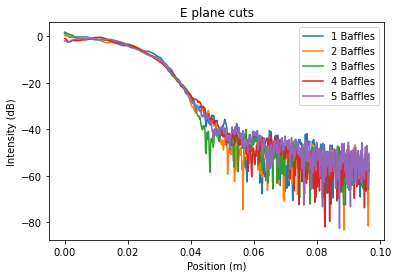

In [1]:
# Iterates between different numbers of baffles and measures power flow
# Disclaimer: Power calculation may be inaccurate!
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy


fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 500*u.GHz
ll = const.c/ff

wf = poppy.FresnelWavefront(beam_radius=fwhm_, wavelength=ll)

lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
wf *= lenslet_aperture

ring = poppy.CircularAperture(radius=0.0381*u.m)
wf *= ring
y, x = wf.coordinates()
initial_power=np.sum(wf.intensity)

nbaff_power=np.zeros([5,1])
nbaff_spill=np.zeros([5,1])
for nbaff in range(1,6):
    wf_it=wf
    wf_it.propagate_fresnel(8.9238*u.cm+(5-nbaff)*u.cm)

    # up to 5 rings, each 2 cm apart
    for dummyvar in np.arange(nbaff,6):
        wf_it.propagate_fresnel(2*u.cm)
        wf_it *= ring
    
    wf_it.propagate_fresnel(14.1455*u.cm)

    temp = wf_it.intensity
    for m in np.arange(0,2048,dtype=int):
        for n in np.arange(0,2048,dtype=int):
            if (0.05)**2 < x[m,n]**2 + y[m,n]**2 :
                nbaff_spill[nbaff-1] += temp[m,n]  
            else:
                nbaff_power[nbaff-1] += temp[m,n]
    print('Transmitted power with '+str(nbaff)+' baffles:')
    print(str(100*nbaff_power[nbaff-1]/initial_power)+'%')
    print('Power spilled with '+str(nbaff)+' baffles:')
    print(str(100*nbaff_spill[nbaff-1]/initial_power)+'%')
    
    plt.plot(x[wf_it.intensity.shape[1]//2,1024:], 10*np.log10(wf_it.intensity[wf_it.intensity.shape[1]//2,1024:]),label=str(nbaff)+" Baffles")
    
plt.legend()
plt.title("E plane cuts")
plt.xlabel("Position (m)")
plt.ylabel("Intensity (dB)")
plt.show()

#a=0 # Toggles zoom
#b=2048-a
#fig, ax = plt.subplots()
#c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],z2[a:b,a:b])
#fig.colorbar(c,ax=ax)
#plt.show()

% Power transmitted:
99.268469373748%
% Power spilled:
0.020127135568681627%


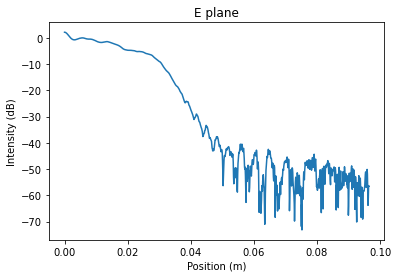

In [2]:
# Simulation is similar to the one portrayed in the 3d model
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy


fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 500*u.GHz
ll = const.c/ff

wf = poppy.FresnelWavefront(beam_radius=fwhm_, wavelength=ll)

lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
wf *= lenslet_aperture

ring = poppy.CircularAperture(radius=0.0381*u.m)
wf *= ring
y, x = wf.coordinates()
initial_power=np.sum(wf.intensity)

wf.propagate_fresnel(0.635*u.cm)

# 3 groups of 0.635 cm spaced baffles, each 2.8 cm apart
for dummyvar in np.arange(1,4):
    for dummyvar2 in np.arange(1,4):
        wf *= ring    
        wf.propagate_fresnel(0.635*u.cm)
    wf *= ring
    wf.propagate_fresnel(2.8*u.cm)
    
# top group of 9 baffles which are 1 mm wider but still 0.635 cm apart
ring = poppy.CircularAperture(radius=0.0382*u.m)
for dummyvar in np.arange(1,9):
    wf *= ring    
    wf.propagate_fresnel(0.635*u.cm)
wf *= ring    

wf.propagate_fresnel(14.1455*u.cm) # propogate out to center of tertiary

temp = wf.intensity
spill_power, trans_power = 0, 0
for m in np.arange(0,2048,dtype=int):
    for n in np.arange(0,2048,dtype=int):
        if (0.05)**2 < x[m,n]**2 + y[m,n]**2 :
            spill_power += temp[m,n]  
        else:
            trans_power += temp[m,n]

print('% Power transmitted:')
print(str(100*trans_power/initial_power)+'%')
print('% Power spilled:')
print(str(100*spill_power/initial_power)+'%')            
            
plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]))
    
plt.title("E plane")
plt.xlabel("Position (m)")
plt.ylabel("Intensity (dB)")
plt.show()

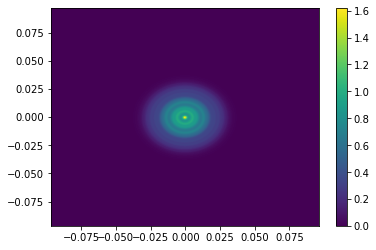

In [3]:
a=0 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],temp[a:b,a:b])
fig.colorbar(c,ax=ax)
plt.show()

% Power transmitted @ 480.0 GHz:
99.24757116632426%
% Power spilled @ 480.0 GHz:
0.021882499579826506%
% Power transmitted @ 540.0 GHz:
99.3030482606458%
% Power spilled @ 540.0 GHz:
0.020573349943529596%


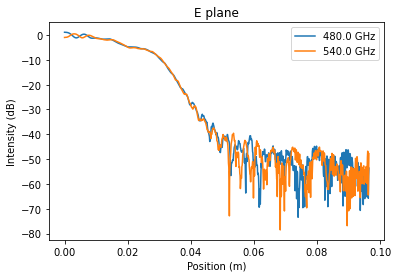

In [4]:
# Check frequency dependence
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy


fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ffs = [480*u.GHz,540*u.GHz]
for ff in ffs:
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=fwhm_, wavelength=ll)

    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    ring = poppy.CircularAperture(radius=0.0381*u.m)
    wf *= ring
    y, x = wf.coordinates()
    initial_power=np.sum(wf.intensity)

    wf.propagate_fresnel(0.635*u.cm)

    # 3 groups of 0.635 cm spaced baffles, each 2.8 cm apart
    for dummyvar in np.arange(1,4):
        for dummyvar2 in np.arange(1,4):
            wf *= ring    
            wf.propagate_fresnel(0.635*u.cm)
        wf *= ring
        wf.propagate_fresnel(2.8*u.cm)
    
    # top group of 9 baffles which are 1 mm wider but still 0.635 cm apart
    ring = poppy.CircularAperture(radius=0.0382*u.m)
    for dummyvar in np.arange(1,9):
        wf *= ring    
        wf.propagate_fresnel(0.635*u.cm)
    wf *= ring    

    wf.propagate_fresnel(14.1455*u.cm) # propogate out to center of tertiary

    temp = wf.intensity
    spill_power, trans_power = 0, 0
    for m in np.arange(0,2048,dtype=int):
        for n in np.arange(0,2048,dtype=int):
            if (0.05)**2 < x[m,n]**2 + y[m,n]**2 :
                spill_power += temp[m,n]  
            else:
                trans_power += temp[m,n]

    print('% Power transmitted @ '+str(ff)+':')
    print(str(100*trans_power/initial_power)+'%')
    print('% Power spilled @ '+str(ff)+':')
    print(str(100*spill_power/initial_power)+'%')            
            
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(ff))

plt.legend()    
plt.title("E plane")
plt.xlabel("Position (m)")
plt.ylabel("Intensity (dB)")
plt.show()